## With Carbon feedback
Growth control is the main purpose of having a feedback from carbon content on the growth rate.


In [1]:
from CPlantBox_PiafMunch import * #import all the libraries

In [389]:
name = "carbon2020.xml"
plant = pb.Plant()

# 2. A split pot experiment
topBox = pb.SDF_PlantBox(22, 20, 5)
#topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
# sideBox = pb.SDF_PlantBox(12, 12, 35)
# left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
# right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
sideBox = pb.SDF_PlantBox(10, 20, 35)
left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
box_ = []
box_.append(topBox)
box_.append(left)
box_.append(right)
splitBox = pb.SDF_Union(box_)


# Set geometry: rotatedRhizotron, splitBox, or rhizoTube
plant.setGeometry(splitBox)
#plant.write("splitBox.py")
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)

carbon_logger = []
root_length_logger = []
taproot_n_all = []

In [401]:


# absolute respiration maintenance of plant segment = volumen of the segment
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for i in range(1,14): # how many i*days to simulation
    plant.setGeometry(splitBox)
    day = 1 # the step of every loop (day)
    hour = 24 # the hour of every loop (hour) used in PiafMunch
    plant.simulate(day) # start simulation
    organ = plant.getOrgans()
    plant.write("{}{}{}.vtp".format("only_Q_ST_test",str(name),i*day)) #writes vtp the name is followed by the number of days simulated
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    Seg_radius = [0]*((len(organ))+1) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    nodeIDtoOrgan = [0]*plant.getNumberOfNodes() #
    r_k1 = 1e-9 # magnitude midification, because the realistic value in literature need to be found
    k = 0
    ########################################## python nodes conversion #########################################
    
    nodes_organtype = dict_all['nodes_organtype']
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & (nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # no seed, root, one connection
    # source nodes
    N1L_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # no seed, stem or leaf, one connection

    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    
    for k in range(0, len(organ)):  # get all the organs
        Seg_radius[k] = organ[k].getParam().a #the diameter of root
        j=0
        for j in range(0,organ[k].getNumberOfNodes()): # get all segments in one organs
            nodeIDtoOrgan[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
            Carbon_main = Seg_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx *r_k1 # calculate the maintenance by volume 
            # Carbon_main = 0
            # print(Carbon_main)  absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main
    
    taproot_length = [0] * (len(plant.getOrgans())+1)
    taproot_n =[]
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
#     for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
#         if j == taproot_n[0] or organ_i.getParent().getId() == 1: # first taproot
#             Soil_water[j] = 0.1
#         elif j == taproot_n[1] or organ_i.getParent().getId() == 2:
#             Soil_water[j] = 0.1        
#         else:
#             Soil_water[j] = 0.1
        
        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    ################################# coupling layer with piafmunch ###################################################
    
    # pass the absolute carbon maintentance to piafmunch
    write_PiafMunch_parameter(dict_all['node_connection'], dict_all['nodes_organtype'], dict_all['nodes_r_st'], dict_all['unq_cnt'], Soil_water, k1, piafmunch_outputname,hour)
    # call piafmunch and rename the output file of the PiafMunch
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
    now = datetime.datetime.now()
    os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
    ########################## convert carbon to growth rate ###########################################
    piaf_output = read_output(name,  dict_all["node_connection"])
    one_carbon_log = []
    for i in N1R_node: # CPlantBox growth rate: cm day-1
        # print(i)
        carbon_content = piaf_output["Q_ST"][-1][int(i[0])-1]* 1e5 # directly pass the Q_ST * 1e5 to carbon content
        one_carbon_log.append(carbon_content)
        organ[nodeIDtoOrgan[int(i[0])-1]].getParam().r =         carbon_content 
  #  print(plant.getSeed().getNumberOfChildren())
    carbon_logger.append(one_carbon_log)
    ############################################length logger ###########################
    

    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: #make sure it is taproot: 
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
    root_length_logger.append(taproot_length)

 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

output successful
output successful
output successful
output successful
output successful
output successful
output successful
output successful
output successful
output successful
output successful
output successful
output successful


In [ ]:
Soil_water

In [ ]:
carbon_logger

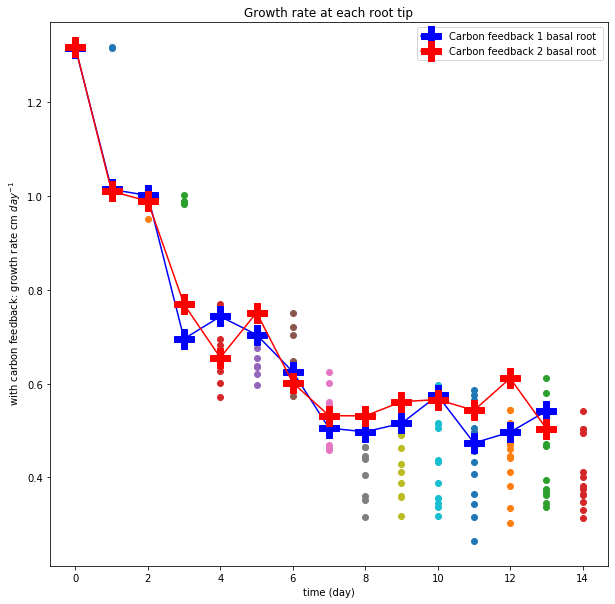

In [400]:
f1=plt
f1.title("Growth rate at each root tip")
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    f1.plot(x,carbon_logger[i], marker = "o", linestyle="")
f1.ylabel(" with carbon feedback: growth rate cm $day^{-1}$")
f1.xlabel("time (day)")
a1 = f1.plot(days1, root_1_c_cf, color= "blue", marker = "P", label= "Carbon feedback 1 basal root ", markersize = "20")
a2 = f1.plot(days1, root_2_c_cf, color= "red", marker = "P", label= "Carbon feedback 2 basal root", markersize = "20")
f1.legend()

In [402]:
root_ho_c = carbon_logger
root_ho_l = root_length_logger

In [407]:
root_ho_l

[[1.9752070377333908, 1.9752070377333908, 0, 0, 0],
 [3.938539970379556, 0, 3.9399406718840106, 0, 0, 0, 0, 0],
 [5.8042295727059035, 0, 5.7771140185942444, 0, 0, 0, 0, 0],
 [8.973576836713725, 0, 0, 0, 8.951893964215552, 0, 0, 0, 0, 0, 0, 0, 0],
 [11.347173950916321, 0, 0, 0, 11.314132515686348, 0, 0, 0, 0, 0, 0, 0, 0],
 [13.747698592947977, 0, 0, 0, 13.496346155919673, 0, 0, 0, 0, 0, 0, 0, 0],
 [16.75468962483946,
  0,
  0,
  0,
  0,
  16.455285638369627,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [19.793114577571146,
  0,
  0,
  0,
  0,
  0,
  19.45365010713043,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [21.77063267343865,
  0,
  0,
  0,
  0,
  0,
  21.834231476314134,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [23.719602846051178,
  0,
  0,
  0,
  0,
  0,
  24.12546680963457,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [25.77263876214288,
  0,
  0,
  0,
  0,
  0,
  26.172666414718712,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [28.07279562046

Text(0, 0.5, 'length (cm)')

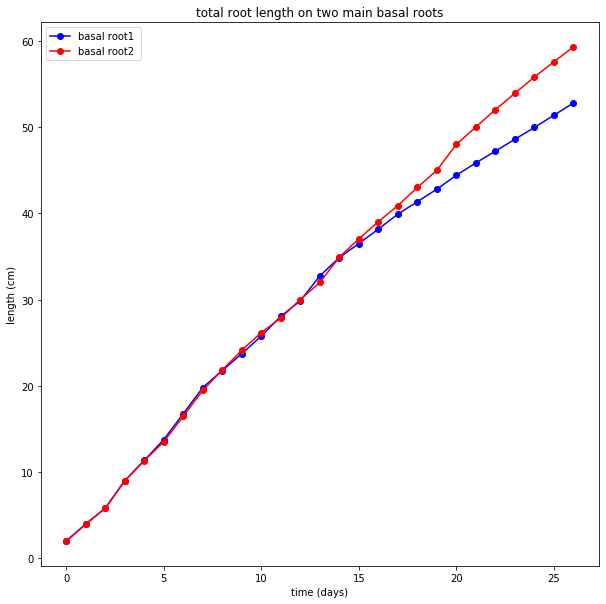

In [405]:
import matplotlib.patches as patches
root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
for i, length_i in enumerate(root_ho_l):
    root_1_l_cf.append(length_i[np.array(root_ho_l[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_ho_l[i]).nonzero()[0][1]])
    root_1_c_cf.append(root_ho_c[i][np.array(root_ho_l[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_ho_c[i][np.array(root_ho_l[i]).nonzero()[0][1]])
    
    
days1 = range(27)
# days1 = [1,2,3,4,5,6,7,8,9]
# days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]


fig,f2=plt.subplots(1)
f2.plot(days1, root_1_l_cf, color= "blue", marker = "o", label= "basal root1 ")
f2.plot(days1, root_2_l_cf, color= "red", marker = "o", label= "basal root2 ")
f2.legend()
plt.title("total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

# f2.add_patch(
#      patches.Rectangle(
#         (0.0, 0),
#         9,
#         23,
#         fill=False, color="purple" , label = "homogeneous soil water"     # remove background
#      ) ) 
# f2.text(3,27,"homogeneous \n soil water", color = "purple")


# f2.add_patch(
#      patches.Rectangle(
#         (9, 23),
#         19,
#         38,
#         fill=False, color="orange" , label = "homogeneous soil water"     # remove background
#      ) ) 
# f2.text(19,19,"heterogenous \n soil water \n red -0.5 MPa \ blue -0.1 MPa", color = "orange")

Text(19, 19, 'heterogenous \n soil water \n red -0.5 MPa \\ blue -0.1 MPa')

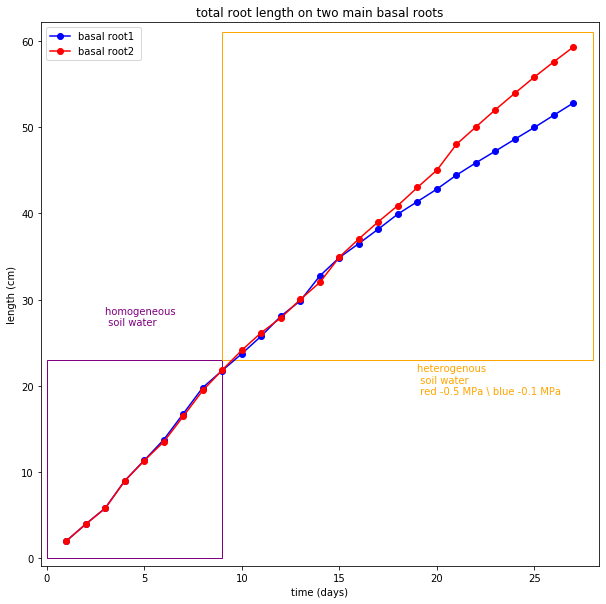

In [366]:
import matplotlib.patches as patches
root_1_l_cf = []
root_1_c_cf = []
root_2_l_cf = []
root_2_c_cf = []
for i, length_i in enumerate(root_he_l):
    root_1_l_cf.append(length_i[np.array(root_he_l[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l[i]).nonzero()[0][1]])
    root_1_c_cf.append(root_he_c[i][np.array(root_he_l[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c[i][np.array(root_he_l[i]).nonzero()[0][1]])
    
    
# days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
days1 = [1,2,3,4,5,6,7,8,9]
days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
fig,f2=plt.subplots(1)
f2.plot(days1, root_1_l_cf, color= "blue", marker = "o", label= "basal root1 ")
f2.plot(days1, root_2_l_cf, color= "red", marker = "o", label= "basal root2 ")
f2.legend()
plt.title("total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

f2.add_patch(
     patches.Rectangle(
        (0.0, 0),
        9,
        23,
        fill=False, color="purple" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(3,27,"homogeneous \n soil water", color = "purple")


f2.add_patch(
     patches.Rectangle(
        (9, 23),
        19,
        38,
        fill=False, color="orange" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(19,19,"heterogenous \n soil water \n red -0.5 MPa \ blue -0.1 MPa", color = "orange")

In [332]:
root_noc_c = carbon_logger
root_noc_l = root_length_logger

In [177]:
root_he_c
root_he_l

[[1.9752070377333908, 1.9752070377333908, 0, 0, 0],
 [3.938539970379556, 0, 3.9399406718840106, 0, 0, 0, 0, 0],
 [5.804226729471704, 0, 5.777107017011005, 0, 0, 0, 0, 0],
 [8.973583274123948, 0, 0, 0, 8.951877422422898, 0, 0, 0, 0, 0, 0, 0, 0],
 [11.34718577524106, 0, 0, 0, 11.314113665620514, 0, 0, 0, 0, 0, 0, 0, 0],
 [13.747743077176743, 0, 0, 0, 13.496286797797445, 0, 0, 0, 0, 0, 0, 0, 0],
 [16.7548254689542, 0, 0, 0, 0, 16.455129432687993, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [19.793297768865514,
  0,
  0,
  0,
  0,
  0,
  19.453284851904833,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

In [226]:
root_3_l = root_length_logger

In [223]:
f=plt
f.plot(piaf_output["Q_ST"][:,8])
f.plot(piaf_output["Q_ST"][:,16])

[[0, 0, 0, 0, 0],
 [0.6900076905179044, 0, 0.6900076905179044, 0, 0, 0, 0, 0],
 [1.6238068459715733, 0, 1.6204350662911853, 0, 0, 0, 0, 0],
 [3.8668197871612557, 0, 0, 0, 3.8647867981235398, 0, 0, 0, 0, 0, 0, 0, 0]]

In [50]:
 for i in N1R_node: # CPlantBox growth rate: cm day-1
        # print(i)
        carbon_content = piaf_output["Q_ST"][-1][int(i[0])-1]* 1e5 # directly pass the Q_ST * 1e5 to carbon content
        one_carbon_log.append(carbon_content)
        organ[nodeIDtoOrgan[int(i[0])-1]].getParam().r =         carbon_content 

TypeError: 'plantbox.Leaf' object does not support indexing

# No carbon feedback

In [312]:
name = "carbon2020.xml"
plant = pb.Plant()

# 2. A split pot experiment
topBox = pb.SDF_PlantBox(22, 20, 5)
#topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
# sideBox = pb.SDF_PlantBox(12, 12, 35)
# left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
# right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
sideBox = pb.SDF_PlantBox(10, 20, 35)
left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
box_ = []
box_.append(topBox)
box_.append(left)
box_.append(right)
splitBox = pb.SDF_Union(box_)


# Set geometry: rotatedRhizotron, splitBox, or rhizoTube
plant.setGeometry(splitBox)
#plant.write("splitBox.py")
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)

carbon_logger = []
root_length_logger = []
taproot_n_all = []

In [313]:


# absolute respiration maintenance of plant segment = volumen of the segment
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for i in range(1,10): # how many i*days to simulation
    plant.setGeometry(splitBox)
    day = 1 # the step of every loop (day)
    hour = 24 # the hour of every loop (hour) used in PiafMunch
    plant.simulate(day) # start simulation
    organ = plant.getOrgans()
    plant.write("{}{}{}.vtp".format("only_Q_ST_test",str(name),i*day)) #writes vtp the name is followed by the number of days simulated
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    Seg_radius = [0]*((len(organ))+1) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    nodeIDtoOrgan = [0]*plant.getNumberOfNodes() #
    r_k1 = 1e-9 # magnitude midification, because the realistic value in literature need to be found
    k = 0
    ########################################## python nodes conversion #########################################
    
    nodes_organtype = dict_all['nodes_organtype']
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & (nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # no seed, root, one connection
    # source nodes
    N1L_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # no seed, stem or leaf, one connection

    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    
    for k in range(0, len(organ)):  # get all the organs
        Seg_radius[k] = organ[k].getParam().a #the diameter of root
        j=0
        for j in range(0,organ[k].getNumberOfNodes()): # get all segments in one organs
            nodeIDtoOrgan[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
            Carbon_main = Seg_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx *r_k1 # calculate the maintenance by volume 
            # Carbon_main = 0
            # print(Carbon_main)  absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main
    
    taproot_length = [0] * (len(plant.getOrgans())+1)
    taproot_n =[]
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
    for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
        if j == taproot_n[0] or organ_i.getParent().getId() == 1: # first taproot
            Soil_water[j] = 0.1
        elif j == taproot_n[1] or organ_i.getParent().getId() == 2:
            Soil_water[j] = 0.1        
        
        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    ################################# coupling layer with piafmunch ###################################################
    
#     # pass the absolute carbon maintentance to piafmunch
#     write_PiafMunch_parameter(dict_all['node_connection'], dict_all['nodes_organtype'], dict_all['nodes_r_st'], dict_all['unq_cnt'], Soil_water, k1, piafmunch_outputname,hour)
#     # call piafmunch and rename the output file of the PiafMunch
#     os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
#     now = datetime.datetime.now()
#     os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
#     ########################## convert carbon to growth rate ###########################################
    piaf_output = read_output(name,  dict_all["node_connection"])
    one_carbon_log = []
    for i in N1R_node: # CPlantBox growth rate: cm day-1
        # print(i)
        carbon_content = piaf_output["Q_ST"][-1][int(i[0])-1]* 1e5 # directly pass the Q_ST * 1e5 to carbon content
        one_carbon_log.append(organ[nodeIDtoOrgan[int(i[0])-1]].getParam().r)
        #organ[nodeIDtoOrgan[int(i[0])-1]].getParam().r =         carbon_content 
  #  print(plant.getSeed().getNumberOfChildren())
    carbon_logger.append(one_carbon_log)
    ############################################length logger ###########################
    

    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: #make sure it is taproot: 
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
    root_length_logger.append(taproot_length)

 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

Text(19, 19, 'heterogenous \n soil water \n red -0.5 MPa \\ blue -0.1 MPa')

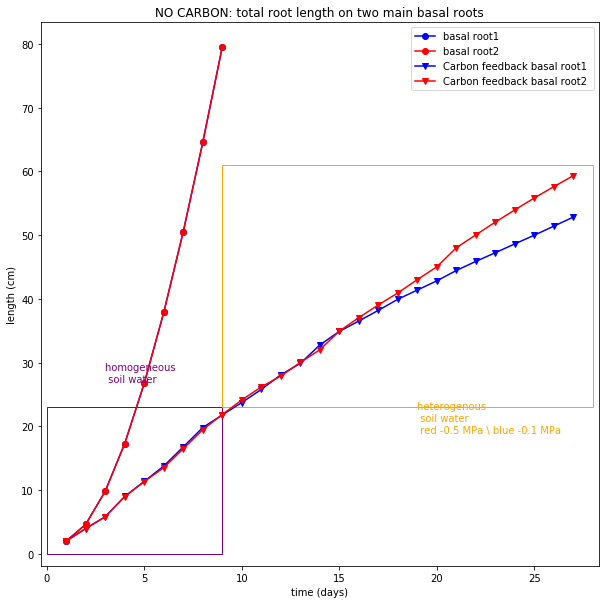

In [324]:
import matplotlib.patches as patches
root_1_l = []
root_2_l = []
for i, length_i in enumerate(root_length_logger):
    root_1_l.append(length_i[np.array(root_length_logger[i]).nonzero()[0][0]])
    root_2_l.append(length_i[np.array(root_length_logger[i]).nonzero()[0][1]])

days = [1,2,3,4,5,6,7,8,9]


fig,f2=plt.subplots(1)
f2.plot(days, root_1_l, color= "blue", marker = "o", label= "basal root1 ")
f2.plot(days, root_2_l, color= "red", marker = "o", label= "basal root2 ")
f2.legend()
plt.title("NO CARBON: total root length on two main basal roots")
plt.xlabel("time (days)")
plt.ylabel("length (cm)")

days1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
f2.plot(days1, root_1_l_cf, color= "blue", marker = "v", label= "Carbon feedback basal root1 ")
f2.plot(days1, root_2_l_cf, color= "red", marker = "v", label= "Carbon feedback basal root2 ")
f2.legend()


f2.add_patch(
     patches.Rectangle(
        (0.0, 0),
        9,
        23,
        fill=False, color="purple" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(3,27,"homogeneous \n soil water", color = "purple")


f2.add_patch(
     patches.Rectangle(
        (9, 23),
        19,
        38,
        fill=False, color="orange" , label = "homogeneous soil water"     # remove background
     ) ) 
f2.text(19,19,"heterogenous \n soil water \n red -0.5 MPa \ blue -0.1 MPa", color = "orange")


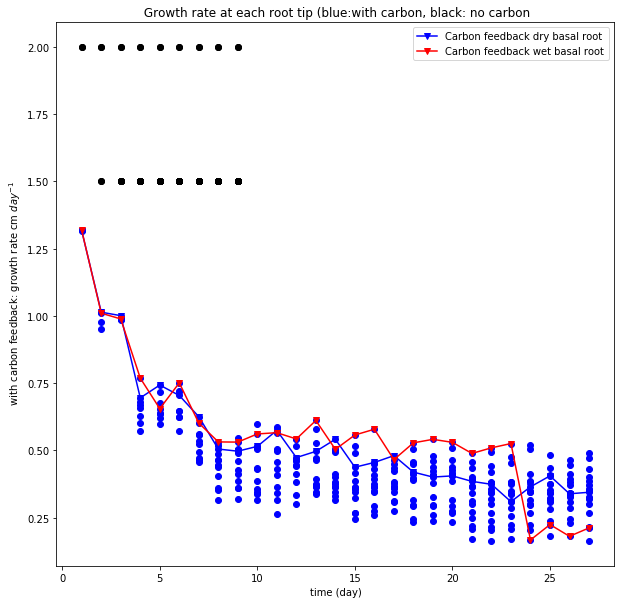

In [343]:
f1=plt
f1.title(" Growth rate at each root tip (blue:with carbon, black: no carbon")
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    f1.plot(x,carbon_logger[i], marker = "o", linestyle="", color = "black")
f1.ylabel(" with carbon feedback: growth rate cm $day^{-1}$")
f1.xlabel("time (day)")
for i, day in enumerate(root_he_c):
    x = [i+1]*len(day)
    f1.plot(x,root_he_c[i], marker = "o", linestyle="", color = "blue")
a1 = f1.plot(days1, root_1_c_cf, color= "blue", marker = "v", label= "Carbon feedback dry basal root ")
a2 = f1.plot(days1, root_2_c_cf, color= "red", marker = "v", label= "Carbon feedback wet basal root")
f1.legend()


In [35]:
N1R_node
for i, roottip in enumerate(N1R_node): 
    print(roottip[0]-1)
    print(nodeIDtoOrgan[int(roottip[0]-1)])

142.0
1
144.0
2
146.0
3
149.0
0
151.0
5
153.0
6
156.0
7
158.0
4


In [36]:
for i,organ enumerate plant.getOrgans():
    print(plant.getOrgans()[i].getPI())

SyntaxError: invalid syntax (<ipython-input-36-8931766144a0>, line 1)

In [55]:
for j,organ in enumerate(plant.getOrgans()): # get all segments in one organs
    if j == taproot_n[0] or organ.getParent().getId() == 1: # first taproot
        Soil_water[j] = 0.1
    elif j == taproot_n[1] or organ.getParent().getId() == 2:
        Soil_water[j] = 0.5
#     print(organ.getParent().getId())# set an id, so we can get the organ number from a node number
print(Soil_water)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
for k in range(0, len(organ)):  # get all the organs
    Seg_radius[k] = organ[k].getParam().a #the diameter of root
    j=0
    for j in range(0,organ[k].getNumberOfNodes()): # get all segments in one organs
        nodeIDtoOrgan[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
        print(k)

In [ ]:
nodeIDtoOrgan

In [46]:
length_logger =[]
taproot_n = []
taproot_length = [0] * (len(plant.getOrgans())+1)
for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
    if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
        taproot_length[root_n] = taproot_length[root_n] + root.getLength()
        taproot_n.append(root_n)
        # plant.getOrgans()[root_n].getLength()
        # print("taproot", root_n)
    elif root.organType() == 2: 
        # print("lateral",root.getParent().organType() ,  root_n)
        # print(root.getParent().getId())
        taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
        length_logger.append(taproot_length)

In [11]:
taproot_n

[0, 4]

In [63]:
root_length_logger

[[5.8042295727059035, 0, 5.777105120927999, 0, 0, 0, 0, 0],
 [5.8042295727059035, 0, 5.777105120927999, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0],
 [8.973574964382626, 0, 0, 0, 8.95187888151636, 0, 0, 0, 0, 0, 0, 0, 0]]

In [53]:
carbon_logger

[[1.02119, 0.97453, 1.0097800000000001, 0.94774],
 [0.507528,
  0.489009,
  0.46643599999999996,
  0.432213,
  0.530354,
  0.5292150000000001,
  0.5250509999999999,
  0.47243699999999994],
 [0.680918,
  0.668493,
  0.6285229999999999,
  0.5971789999999999,
  0.7597339999999999,
  0.7073539999999999,
  0.646437,
  0.587283],
 [0.7569119999999999,
  0.7238439999999999,
  0.683122,
  0.640183,
  0.731056,
  0.620657,
  0.555297,
  0.5762909999999999],
 [0.718978,
  0.670938,
  0.5936609999999999,
  0.593245,
  0.704311,
  0.707697,
  0.63051,
  0.680666],
 [0.592557,
  0.497737,
  0.47241500000000003,
  0.48858900000000005,
  0.42117,
  0.6412519999999999,
  0.532628,
  0.5826359999999999,
  0.547192,
  0.517054],
 [0.610355,
  0.48473,
  0.510219,
  0.494507,
  0.42913300000000004,
  0.5554790000000001,
  0.5724990000000001,
  0.571927,
  0.5645479999999999,
  0.510891],
 [0.6268769999999999,
  0.504499,
  0.532802,
  0.5125940000000001,
  0.448892,
  0.655659,
  0.562014,
  0.4987250000

In [ ]:
k=0
for k in range(0, len(organ)):  # get all the organs
        Seg_radius[k] = organ[k].getParam().a #the diameter of root
        j=0
        for j in range(0,organ[k].getNumberOfNodes()): # get all segments in one organs
            print(organ[k].getNodeId(j))
            print(k)
            #nodeIDtoOrgan[]=i # set an id, so we can get the organ number from a node number
            # Carbon_main = Seg_radius[k]**2*3.1415926* organ[i].getOrganRandomParameter().dx *r_k1 # calculate the maintenance by volume 
            Carbon_main = 0
            # print(Carbon_main)  absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main